In [441]:
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, roc_curve

# Model selection
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline

# Feature selection
from sklearn.feature_selection import RFE

# Plotting
import altair as alt

In [199]:
X_train = pd.read_csv("data/clean-data/Xtrain-clean-autism-screening.csv", index_col=0)
y_train = pd.read_csv("data/clean-data/ytrain-clean-autism-screening.csv", index_col=0)
X_test = pd.read_csv("data/clean-data/Xtest-clean-autism-screening.csv", index_col=0)
y_test = pd.read_csv("data/clean-data/ytest-clean-autism-screening.csv", index_col=0)


In [200]:
# Make validation set 

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=414)

In [201]:
numeric_features = ["age", 
                    "result"]

one_hot_features = ["gender", 
                    "ethnicity", 
                    "jaundice", 
                    "country_of_res", 
                    "used_app_before", 
                    "age_desc", 
                    "relation",
                    "Class/ASD"]

other_columns = list(X_train.columns[0:10])




In [202]:
preprocessor = ColumnTransformer(sparse_threshold=0,
    transformers=[
        ("scale", 
         StandardScaler(), 
         numeric_features),
        ("one_hot", 
         OneHotEncoder(drop=None, 
                       handle_unknown="ignore"), 
         one_hot_features)
    ])

In [203]:
X_train_temp = pd.DataFrame(preprocessor.fit_transform(X_train), 
            index = X_train.index,
            columns = (numeric_features + 
                       list(preprocessor
                           .named_transformers_["one_hot"]
                           .get_feature_names(one_hot_features)))
                      )

X_test_temp = pd.DataFrame(preprocessor.transform(X_test),
                     index = X_test.index,
                     columns = X_train_temp.columns)

X_valid_temp = pd.DataFrame(preprocessor.transform(X_valid),
                     index = X_valid.index,
                     columns = X_train_temp.columns)

X_train = X_train_temp.join(X_train[other_columns])
X_test = X_test_temp.join(X_test[other_columns])
X_valid = X_valid_temp.join(X_valid[other_columns])

In [204]:
le = LabelEncoder()

y_train = le.fit_transform(y_train.to_numpy().ravel())
y_test = le.transform(y_test.to_numpy().ravel())
y_valid = le.transform(y_valid.to_numpy().ravel())

In [205]:
# lr = LogisticRegression()
# print("LR score on train set:", lr.fit(X_train, y_train).score(X_train, y_train))
# print("LR score on test set:", lr.score(X_test, y_test))

# dt = DecisionTreeClassifier()
# print("DT score on train set:", dt.fit(X_train, y_train).score(X_train, y_train))
# print("DT score on test set:", dt.score(X_test, y_test))

# rf = RandomForestClassifier()
# print("RF score on train set:", rf.fit(X_train, y_train).score(X_train, y_train))
# print("RF score on test set:", rf.score(X_test, y_test))

# svm = SVC()
# print("SVM score on train set:", svm.fit(X_train, y_train).score(X_train, y_train))
# print("SVM score on test set:", svm.score(X_test, y_test))

# knn = KNeighborsClassifier()
# print("KNN score on train set:", knn.fit(X_train, y_train).score(X_train, y_train))
# print("KNN score on test set:", knn.score(X_test, y_test))

In [206]:
## Pipeline

lr = LogisticRegression()

dt = DecisionTreeClassifier()

rf = RandomForestClassifier()

svm = SVC()

knn = KNeighborsClassifier()

estimators = [lr, dt, rf, svm, knn]

# pipe_steps = [('poly', PolynomialFeatures(...)),
#               ('lr', LogisticRegression(...)),
#               ('dt', DecisionTreeClassifier(...)),
#               ('rf', RandomForestClassifier(...)),
#               ('svm', SVC(...)),
#               ('knn', KNeighborsClassifier(...))]
             
# pipe = Pipeline(steps = pipe_steps)

# 'linear' kernel takes an insanely long time??
# https://datascience.stackexchange.com/questions/989/svm-using-scikit-learn-runs-endlessly-and-never-completes-execution

params = [{'C':[0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
         'penalty': ['l1', 'l2']},
         {'max_depth': [1, 5, 10, 15, 20, 25, None],
         'max_features': [3, 5, 10, 20, 25, 50, 100, None]},
         {'min_impurity_decrease': [0, 0.25, 0.5],
         'max_features': [3, 5, 10, 20, 50, 100, 'auto']},
         {'C':[0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
         'gamma':[0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]},
         {'n_neighbors': [2, 5, 10, 15, 20, 50, 100],
         'algorithm': ['auto', 'brute']}]


# Scoring = precision to reduce false positives
for i in range(len(estimators)):
    search = GridSearchCV(estimator=estimators[i], 
                          param_grid=params[i],
                          cv = 10,
                          n_jobs=-1,
                         scoring='precision')
    
    search_object = search.fit(X_train, y_train)
    
    print(search_object.best_estimator_)
    print(search_object.best_params_)
    print(search_object.best_score_, "\n\n")

/Users/matt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
{'C': 100, 'penalty': 'l2'}
0.2852380952380952 


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=15, max_features=20, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
{'max_depth': 15, 'max_features': 20}
0.3118648018648019 


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_feature

In [193]:
# the best precision score comes from a random forest classifier with max_features=20 and min_impurity decrease = 0
# and precision = 0.46

In [419]:
rf = RandomForestClassifier(max_features=20, min_impurity_decrease=0)
rf.fit(X_train, y_train).score(X_train, y_train)


1.0

In [420]:
# It gets a perfect score on the train set

In [421]:
rf.score(X_valid, y_valid)

0.8461538461538461

In [422]:
# and ~85% on the validation set

In [424]:
rf.score(X_test, y_test)

0.8370786516853933

In [426]:
pd.DataFrame(confusion_matrix(y_valid, rf.predict(X_valid)))


,0,1
0,120,3
1,19,1


In [225]:
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       150
           1       0.36      0.14      0.21        28

    accuracy                           0.83       178
   macro avg       0.61      0.55      0.55       178
weighted avg       0.78      0.83      0.79       178



In [226]:
questions = ['A1_Score',
       'A2_Score',
       'A3_Score',
       'A4_Score',
       'A5_Score',
       'A6_Score',
       'A7_Score',
       'A8_Score',
       'A9_Score',
       'A10_Score']

questions_train_df = X_train[questions]

questions_valid_df = X_valid[questions]

questions_test_df = X_test[questions]

In [362]:
# Attribution: Varada Kolhatkar

class ForwardSelection:
    def __init__(self, 
                 model, 
                 min_features=None, 
                 max_features=None, 
                 scoring=None, 
                 cv=None):
        """
        WRITE YOUR DOCSTRING
        """
        self.max_features = max_features
        if min_features is None:
            self.min_features = 1
        else:
            self.min_features = min_features

        self.model = model
        self.scoring = scoring
        self.cv = cv
        self.ftr_ = []
        return
    
    def fit(self, X, y):
        """
        WRITE YOUR DOCSTRING        
        """
        
        error = np.inf
        best = None
        feature_index = list(range(0, (X.shape[1])))
        errors = []
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=514)

        X_temp = X_train

        while error > 0.0:
            print(error)
            if best is not None:
                if best not in feature_index:
                    del feature_index[-2]
#                     del feature_index[-1]
                    break
                feature_index.remove(best)

            for i in feature_index:
#                 print('sup')
                self.model.fit(X_temp[:, self.ftr_ + [i]], y_train)
                temp_error = 1-np.mean(cross_val_score(self.model, X[:, self.ftr_ + [i]], y, scoring='f1'))
                print(temp_error)

                if temp_error < error:
                    error = temp_error
                    best = i

            errors.append(round(error, 3))

            if len(errors) > 2:
                if errors[-1] >= errors[-2]:
                    break

            if self.max_features is not None:
                if len(errors) > self.max_features:
                    break

            self.ftr_.append(best)


    def transform(self, X, y=None):
        """
        WRITE YOUR DOCSTRING        
        """
        return X[:, self.ftr_]
    

In [363]:
fs = ForwardSelection(RandomForestClassifier(), max_features=None)

In [364]:
list(range(0, (questions_train_df.shape[1])))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [365]:
np.mean(cross_val_score(rf, questions_train_df, y_train, scoring='recall'))

/Users/matt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/Users/matt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/Users/matt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/Users/matt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarnin

nan

In [366]:
fs.fit(questions_train_df.to_numpy(), y_train)

inf
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [353]:
fs.ftr_

[1, 1]

In [367]:
# No single one question is better than any other one question so forward selection won't work
# Or it just won't work with a random forest


In [377]:
rf.max_features

20

In [392]:
rfe  =RFE(RandomForestClassifier(), n_features_to_select=5)

rfe.fit(questions_train_df, y_train)

RFE(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                     class_weight=None, criterion='gini',
                                     max_depth=None, max_features='auto',
                                     max_leaf_nodes=None, max_samples=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=100, n_jobs=None,
                                     oob_score=False, random_state=None,
                                     verbose=0, warm_start=False),
    n_features_to_select=5, step=1, verbose=0)

In [394]:
np.where(rfe.ranking_ == 1)[0]

array([1, 6, 7, 8, 9])

In [412]:
X_train_best_5 = questions_train_df.to_numpy()[:,np.where(rfe.ranking_ == 1)[0]]
X_test_best_5 = questions_test_df.to_numpy()[:,np.where(rfe.ranking_ == 1)[0]]
X_valid_best_5 = questions_valid_df.to_numpy()[:,np.where(rfe.ranking_ == 1)[0]]

In [413]:
rf2 = RandomForestClassifier()

rf2.fit(X_train_best_5, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [415]:
pd.DataFrame(confusion_matrix(y_valid, rf2.predict(X_valid_best_5)))

,0,1
0,122,1
1,19,1


In [ ]:
# Using just the top 5 questions gets a much worse result than using all the features


In [416]:
# Try all questions:
rf3 = RandomForestClassifier()

rf3.fit(questions_train_df, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [442]:
conf_matrix = pd.DataFrame(confusion_matrix(y_test, rf.predict(X_test)))

In [452]:
final_matrix = conf_matrix.rename(columns={0:"predicted no", 1:'predicted yes'}, 
                  index={0:"actual no", 1:'actual yes'}).swapaxes(0,1)

pd.to_cs

,actual no,actual yes
predicted no,145,24
predicted yes,5,4


In [371]:
X_temp = X_train.to_numpy()

fs.transform(X_temp)

array([[-0.14512307, -0.14512307],
       [-0.84491144, -0.84491144],
       [-0.19510795, -0.19510795],
       ...,
       [ 0.15478623,  0.15478623],
       [ 1.20446878,  1.20446878],
       [-0.79492656, -0.79492656]])

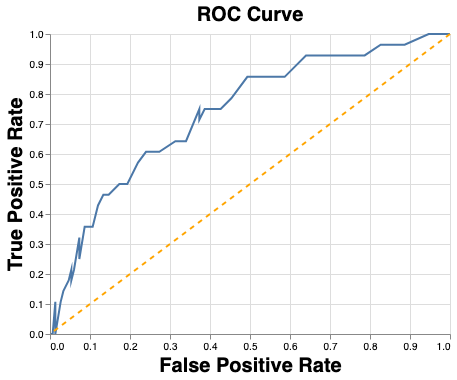

In [435]:
# ROC curve

fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:,1])

roc_df = pd.DataFrame({"fpr":fpr, "tpr":tpr})

line_df = pd.DataFrame({"start":[0,1], "end":[0,1]})

roc = alt.Chart(roc_df).mark_line().encode(
    x = alt.X("fpr:Q"),
    y = alt.Y("tpr:Q")
)
    
line = alt.Chart(line_df).mark_line(strokeDash=[5,5], color="orange").encode(
    x = alt.X("start:Q", axis=alt.Axis(title="False Positive Rate")),
    y = alt.Y("end:Q", axis=alt.Axis(title="True Positive Rate"))
)
    
(roc + line).configure_axis(titleFontSize=20).properties(title="ROC Curve").configure_title(fontSize=20)